## Fisher matrix for cross-spectrum bandpowers

In this notebook, we perform a simple Fisher forecast for the bandpowers of the cross-spectrum between a spectroscopic galaxy survey and a 21cm IM survey. The forecast is done for each redshift bin independently; correlated noise contributions between redshift bins (e.g. due to foregrounds) are neglected.

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import fastbox

In [2]:
# Set up cosmology and LSST instrumental specs
cosmo = ccl.Cosmology(Omega_c=0.27, 
                      Omega_b=0.045, 
                      h=0.67, 
                      A_s=2.1e-9, 
                      n_s=0.96)
chi = ccl.comoving_radial_distance(cosmo, a=1.) # Precomputes interpolation fn.

In [3]:
# Define ell bins
delta_ell = 4 # ell bin width
ells = np.arange(2, 501, delta_ell)

# Spectro-z bin edges
zmin = 0.8
zmax = 1.0

# Galaxy survey number density
ngal = 1e-5 # Comoving number density of galaxies, Mpc^-3

# IM total survey time and survey area
ttot = 4000. # hrs
sarea = 4000. # deg^2

fsky = sarea / (4.*np.pi * (180./np.pi)**2.)
print("fsky = %3.3f" % fsky)

fsky = 0.097


In [4]:
# Experiment definitions
# (NOTE: Overlap between instrument band and spectro-z bins is not currently checked!)

# MeerKAT single-dish, 64 dishes, UHF band
# 580 - 1015 MHz
inst_meerkatuhf = {
    'name':         "MeerKAT_UHF",
    'type':         "dish",
    'D':            13.5,
    'Ndish':        64,
    'fsky':         fsky,
    'Tsys':         26.,   # in K
    'ttot':         ttot,  # hrs
    'fsky_overlap': fsky,
    'kmax0':        0.14   # Mpc^-1
}

In [5]:
# MeerKAT redshift range
print("MeerKAT UHF band: z = %3.2f -- %3.2f" % (fastbox.forecast.NU21CM/1015.-1., 
                                                fastbox.forecast.NU21CM/580.-1.))

MeerKAT UHF band: z = 0.40 -- 1.45


## Calculate signal and noise angular power spectra

In [6]:
# Get tracers for redshift bin
tracer_gal = fastbox.forecast.tracer_spectro(cosmo, zmin, zmax, kind='galaxy') # dimensionless
tracer_im = fastbox.forecast.tracer_spectro(cosmo, zmin, zmax, kind='im') # units of mK

# Calculate cross-power
Cell_cross = ccl.angular_cl(cosmo, tracer_gal, tracer_im, ells) # units of mK

# Calculate auto-power
Cell_gal = ccl.angular_cl(cosmo, tracer_gal, tracer_gal, ells) # dimensionless
Cell_im = ccl.angular_cl(cosmo, tracer_im, tracer_im, ells) # units of (mK)^2

In [7]:
# IM noise power
Nell_im = fastbox.forecast.noise_im(cosmo, inst_meerkatuhf, ells, zmin, zmax).flatten()

# Galaxy noise power
Ngal_per_ster = fastbox.forecast.number_density_to_area_density(cosmo, 
                                                                ngal=ngal, 
                                                                zmin=zmin, 
                                                                zmax=zmax, 
                                                                degrees=False)
Nell_gal = np.ones_like(ells) / (Ngal_per_ster)

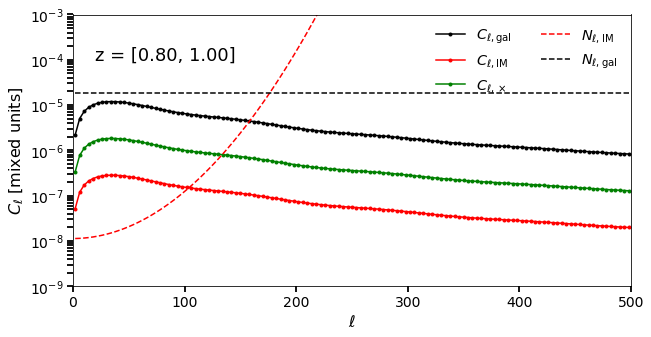

In [8]:
# Plot individual signal and noise spectra
plt.plot(ells, Cell_gal, color='k', marker='.', label=r"$C_{\ell, {\rm gal}}$")
plt.plot(ells, Cell_im, color='r', marker='.', label=r"$C_{\ell, {\rm IM}}$")
plt.plot(ells, Cell_cross, color='g', marker='.', label=r"$C_{\ell, \times}$")

plt.plot(ells, Nell_im, 'r--', label=r"$N_{\ell, {\rm IM}}$")
plt.plot(ells, Nell_gal, 'k--', label=r"$N_{\ell, {\rm gal}}$")

plt.legend(loc='upper right', frameon=False, prop={'size': 'x-large'}, ncol=2)

plt.text(20., 1e-4, "z = [%2.2f, %2.2f]" % (zmin, zmax), fontsize=18.)
plt.xlabel("$\ell$", fontsize=16.)
plt.ylabel("$C_\ell$ [mixed units]", fontsize=16.)

plt.yscale('log')
plt.ylim((1e-9, 1e-3))
plt.xlim((0., 500.))

plt.tick_params(which='both', length=6., width=1.8, labelsize=14.)

plt.gcf().set_size_inches((10., 5.))

## Calculate Fisher matrix

In [9]:
# Calculate cross-power Fisher matrix
F_ell = fastbox.forecast.fisher_bandpowers(ells, 
                                           delta_ell=delta_ell, 
                                           fsky=fsky, 
                                           Cell_gal=Cell_gal, 
                                           Cell_im=Cell_im, 
                                           Cell_cross=Cell_cross, 
                                           Nell_gal=Nell_gal, 
                                           Nell_im=Nell_im)

# Fisher errorbars on cross-spectrum
sigma_cross = 1. / np.sqrt(F_ell) # units of mK

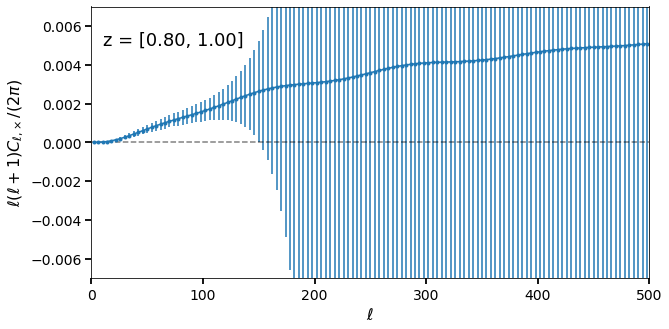

In [10]:
# Plot cross-power spectrum with Fisher errorbars
ell_fac = ells * (ells + 1.) / (2.*np.pi)
plt.errorbar(ells, ell_fac*Cell_cross, yerr=ell_fac*sigma_cross, marker='.')
plt.ylabel(r"$\ell(\ell+1)C_{\ell,\!\times} / (2\pi)$", fontsize=16.)
plt.xlabel(r"$\ell$", fontsize=16.)

plt.axhline(0., color='k', alpha=0.5, ls='dashed')
plt.text(10., 0.005, "z = [%2.2f, %2.2f]" % (zmin, zmax), fontsize=18.)
plt.ylim((-0.007, 0.007))
plt.xlim((0., 500.))

plt.tick_params(which='both', length=6., width=1.8, labelsize=14.)

plt.gcf().set_size_inches((10., 5.))

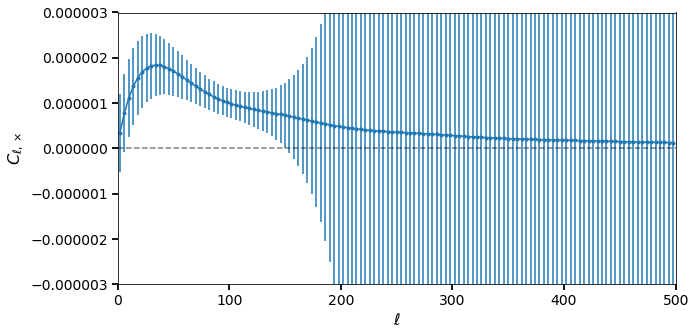

In [11]:
# Plot cross-power with errorbars (C_ell only)
ell_fac = 1.
plt.errorbar(ells, ell_fac*Cell_cross, yerr=ell_fac*sigma_cross, marker='.')
plt.ylabel(r"$C_{\ell,\times}$", fontsize=16.)
plt.xlabel(r"$\ell$", fontsize=16.)

plt.axhline(0., color='k', alpha=0.5, ls='dashed')
plt.ylim((-0.000003, 0.000003))
plt.xlim((0., 500.))

plt.tick_params(which='both', length=6., width=1.8, labelsize=14.)

plt.gcf().set_size_inches((10., 5.))

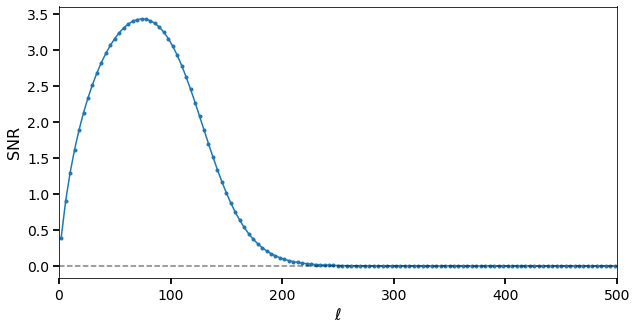

In [12]:
# Plot cross-power with errorbars (C_ell only)
ell_fac = 1.
plt.plot(ells, Cell_cross/sigma_cross, marker='.')
plt.ylabel(r"${\rm SNR}$", fontsize=16.)
plt.xlabel(r"$\ell$", fontsize=16.)

plt.axhline(0., color='k', alpha=0.5, ls='dashed')
#plt.ylim((-0.000003, 0.000003))
plt.xlim((0., 500.))

plt.tick_params(which='both', length=6., width=1.8, labelsize=14.)

plt.gcf().set_size_inches((10., 5.))